<a href="https://colab.research.google.com/github/shrutipingale/IS_699_Project/blob/master/Adjustment_Risk_Intelligence_Analytics_(ARIA)_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.11.13


In [ ]:
%pip install ctgan
%pip install sdv

# Adjustment Risk Intelligence Analytics
<p>
<b>Markets Finance (Product Control) - Prediction of High-Risk Adjustments:</b> A predictive model that would flag potential 'high risk' adjustments considering multiple 'risk indicators' -- A multi-dimensional model that will predict the behaviour by considering linear factors.
</p>

### This notebook includes following steps.

<ol>
  <li>Importing necessary libraries</li>
  <li>Defining Sampling, catagories and creating DataFrame with necessary columns</li>
  <li>Using SDV and CTGAN Synthesizer to create sampling</li>
  <li>Preparing/Splitting Data to train and test ML Models</li>
  <li>Training Classical Machine Learning Models and determine weights</li>
  <li>Further exploring Deep Learning Model Training on Data</li>
</ol>

## 1. Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import scipy.stats as ss

## 2. Defining Sampling

Here we are defining n_sample which determines the number of total records we will have in synthetic data. Along with that we will provide some realistic values of each column which will be used to create a Data Frame.

Values > 270:  33094
1650.0
4995481
500000


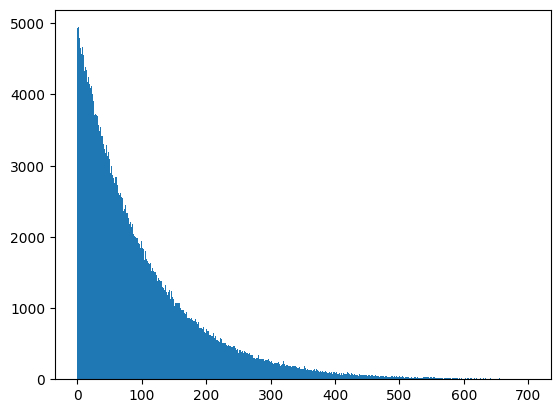

In [ ]:
# Preparing exponential distribution for age
n_samples=500000
start_age=0
end_age=700
scale=100

raw_values = np.random.exponential(scale=scale, size=5000000)
scaled_values = np.floor(raw_values)
shifted_values = scaled_values + start_age

# only select shifted values that are less than 270
age_values = shifted_values[shifted_values <= end_age]

#randomly delete values from shifted_values such that only 50k rows remain
delete_indices = np.random.choice(age_values.size, age_values.size - n_samples, replace=False)
age = np.delete(age_values, delete_indices)

# count shifted values that are = 270
count_248 = np.count_nonzero(age > 270)
print("Values > 270: ", count_248)
print(max(shifted_values))
print(age_values.size)
print(age.size)


# plot shifted_values
import matplotlib.pyplot as plt
plt.hist(age, bins=700)
plt.show()


In [ ]:
# 1. Synthetic Data Generation (500,000 rows)
# Define cardinalities
n_samples = 50_0000
risk_probs = [1.00, 0.0, 0.0, 0.0]  # Not at Risk, Low, Medium, High

# Helper for categorical draws
def sample_category(categories, probs=None, size=n_samples):
    return np.random.choice(categories, size=size, p=probs)

# Define categories
bus_date_types = ['Daily', 'Month End']
msbk_ids = [f"{i:06d}" for i in range(100000, 100000+100)]
account_types = ['BS', 'PnL', 'Other']
acct_name_sl = ['Inventory', 'Brokerage Accrual', 'Trade Payables', 'Accrued Interest', 'Loans', 'Fees', 'Other']
reason_codes = ['FOBO BREAK', 'Cash Breaks', 'Stock/Positions Breaks', 'Other SL breaks', 'Receivables', 'Fails', 'Frees']
ledger_types = ['IFRS', 'USGAAP']
commentaries = ['Unspecified', '']

# currencies = ['USD', 'EUR', 'GBP', 'JPY', 'CHF', 'CAD', 'AUD']
currencies = ['USD']

account_name_gl = [f"GL_{i}" for i in range(10)] # Doing it for 10 GL account
product_types = ['Common Stock - EQUITY', 'ETF - EQUITY', 'Bond - FIXED', 'Future', 'Option', 'Swap']

# Generate raw table
df = pd.DataFrame({
    'BUS_DATE_TYPE': sample_category(bus_date_types, size=n_samples, probs=[0.6, 0.4]),
    'AGE': np.delete(age_values, delete_indices),
    'MSBK_ID': sample_category(msbk_ids),
    'ACCOUNT_TYPE': sample_category(account_types),
    'ACCT_NAME_SL': sample_category(acct_name_sl),
    'REASON_CODE': sample_category(reason_codes),
    'LEDGER_TYPE_CODE': sample_category(ledger_types),
    'CCY_ID_TRANSACTION': sample_category(currencies),
    'ACCOUNT_NAME_GL': sample_category(account_name_gl),
    'AMOUNT': np.round(np.random.normal(loc=0, scale=1e5, size=n_samples), 2),
    'PRODUCT_TYPE': sample_category(product_types),
    'ITEM_AT_RISK': sample_category(['Not at Risk','Low Risk','Medium Risk','High Risk'], probs=risk_probs)
})

In [ ]:
df['ITEM_AT_RISK'].value_counts()

,count
ITEM_AT_RISK,
Not at Risk,500000


<Axes: >

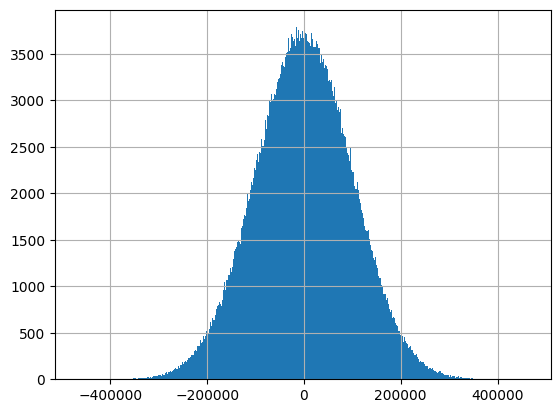

In [ ]:
df['AMOUNT'].hist(bins=500)

<Axes: >

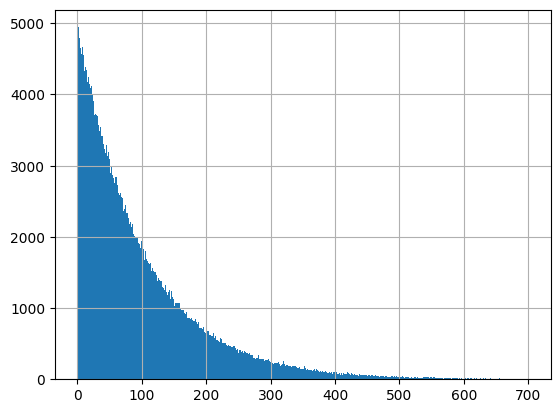

In [ ]:
df['AGE'].hist(bins=700)

# df['AMOUNT'].value_counts()
# df['age'].value_counts()
# df['age'].value_counts()

### Rule based data labeling for base data that we will feed to the CTGAN model to generate synthetic data

##### Rule 1: Any adjustment greater than 100k USD and age > 100 should be flagged as High Risk


In [ ]:
mask = (df['AGE']>100) & (df['AMOUNT'].abs()>=100000)
df.loc[mask, 'ITEM_AT_RISK'] = 'High Risk'

##### Rule 2: Any adjustment greater than 100k USD and age >= 50 and age < 100 should be flagged as Medium Risk


In [ ]:
mask = (df['AGE']<100) & (df['AMOUNT'].abs()>=100000 & (df['AGE']>=50))
df.loc[mask, 'ITEM_AT_RISK'] = 'Medium Risk'

##### Rule 3: Any adjustment greater than 100k USD and age < 50 should be flagged as Low Risk


In [ ]:
mask = (df['AGE']<50) & (df['AMOUNT'].abs()>=100000) & (df['AGE']>=30)
df.loc[mask, 'ITEM_AT_RISK'] = 'Low Risk'

### Reason code specific rules

##### Rule 4: Any Cash Break, Stock and Position Break, Other SL breaks and Frees > 10k USD
*   Not at risk: age 7-90
*   Medium Risk: age 91-270
*   High risk: age >270



In [ ]:
reason_codes = ['Cash Breaks', 'Stock/Positions Breaks', 'Other SL breaks', 'Frees']

mask = (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>=0) & (df['AGE']<=90)

df.loc[mask, 'ITEM_AT_RISK'] = 'Not at Risk'

mask = (df['AMOUNT'].abs()>=10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>=91) & (df['AGE']<=270)
df.loc[mask, 'ITEM_AT_RISK'] = 'Medium Risk'

mask = (df['AMOUNT'].abs()>=10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>270)
df.loc[mask, 'ITEM_AT_RISK'] = 'High Risk'

##### Rule 5: Any FOBO break > 10k USD
*   Low risk: age 7-90
*   Medium Risk: age 91-270
*   High risk: age >270


In [ ]:
mask = (df['AMOUNT'].abs()>=10000) & (df['REASON_CODE']=='FOBO BREAK') & (df['AGE']>=7) & (df['AGE']<=90)
df.loc[mask, 'ITEM_AT_RISK'] = 'Low Risk'

mask = (df['AMOUNT'].abs()>=10000) & (df['REASON_CODE']=='FOBO BREAK') & (df['AGE']>=91) & (df['AGE']<=270)
df.loc[mask, 'ITEM_AT_RISK'] = 'Medium Risk'

mask = (df['AMOUNT'].abs()>=10000) & (df['REASON_CODE']=='FOBO BREAK') & (df['AGE']>270)
df.loc[mask, 'ITEM_AT_RISK'] = 'High Risk'

##### Rule 5: Any Fails, Receivables break > 10k USD
*   Not at risk: age 7-90
*   Low risk: age 91-180
*   Medium Risk: age 181-270
*   High risk: age >270


In [ ]:
reason_codes = ['Receivables', 'Fails']
mask = (df['AMOUNT'].abs()>10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>=7) & (df['AGE']<=90)
df.loc[mask, 'ITEM_AT_RISK'] = 'Not at Risk'

mask = (df['AMOUNT'].abs()>10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>=91) & (df['AGE']<=180)
df.loc[mask, 'ITEM_AT_RISK'] = 'Low Risk'

mask = (df['AMOUNT'].abs()>10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>=181) & (df['AGE']<=270)
df.loc[mask, 'ITEM_AT_RISK'] = 'Medium Risk'

mask = (df['AMOUNT'].abs()>10000) & (df['REASON_CODE'].isin(reason_codes)) & (df['AGE']>270)
df.loc[mask, 'ITEM_AT_RISK'] = 'High Risk'

### Need to add more intricate rules -> GL/SL account specific, etc. IFRS type specific

In [ ]:
reason_codes = ['Receivables']
mask = (df['REASON_CODE'].isin(reason_codes))
df.loc[mask, 'ITEM_AT_RISK'] = 'High Risk'

In [ ]:
# Adding randomness to the data
high_idx = df.sample(frac=0.08, random_state=42).index
df.loc[high_idx, 'ITEM_AT_RISK'] = np.random.choice(['Not at Risk', 'Low Risk', 'Medium Risk', 'High Risk'], size=len(high_idx))

##### Distribution in the end for item at risk

In [ ]:
df['ITEM_AT_RISK'].value_counts()/n_samples

,count
ITEM_AT_RISK,
Not at Risk,0.421478
Medium Risk,0.266386
High Risk,0.198944
Low Risk,0.113192


### Hyper parameter tuning

In [ ]:
# 2. Fit a CTGAN to capture multi-dimensional dependency
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# 3. Prepare ML Model Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models


def train_model(df, epochs, generator_lr, discriminator_lr, batch_size):
  training_data_size = 100000

  #print("Subsampling dataset for CTGAN training to reduce memory usage...")
  #train_df = df.sample(n=500_00, random_state=42)

  metadata = SingleTableMetadata()
  metadata.detect_from_dataframe(data=df)

  print("Initializing CTGANSynthesizer with a single worker (n_jobs=1)...")
  print(f"Training with generator_lr={generator_lr}, discriminator_lr={discriminator_lr}, batch_size={batch_size}, epochs={epochs}")
  ctgan = CTGANSynthesizer(epochs=epochs, metadata=metadata, cuda=True, generator_lr=generator_lr, discriminator_lr=discriminator_lr, batch_size=batch_size)
  print("Fitting CTGANSynthesizer on subsample...")
  ctgan.fit(df)

  print("Sampling synthetic data...")
  synthetic_df = ctgan.sample(training_data_size)
  df_copy = synthetic_df.copy()

  # Split
  label_map = {'Not at Risk': 0, 'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3}

  X = df_copy.drop('ITEM_AT_RISK', axis=1)
  y = df_copy['ITEM_AT_RISK'].map(label_map)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, stratify=y, test_size=0.05, random_state=42
  )
  # Preprocessing
  cat_cols = X.select_dtypes('object').columns.tolist()
  num_cols = X.select_dtypes('number').columns.tolist()
  preprocessor = ColumnTransformer([
      ('num', StandardScaler(), num_cols),
      ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
  ])

  # Classical Models
  models = {
      'logistic_regression': LogisticRegression(max_iter=1000),
      'xgboost': XGBClassifier(depth=12, eval_metric='mlogloss'),
      'lightgbm': LGBMClassifier(),
      # 'svm': SVC(kernel='rbf', C=1.0, gamma='scale')
  }

  for name, clf in models.items():
      pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
      pipe.fit(X_train, y_train)
      preds = pipe.predict(X_test)
      print(name)
      print(classification_report(y_test, preds))
      current_accuracy = accuracy_score(y_test, preds) # Calculate and store accuracy
      print(current_accuracy)

  return pipe, current_accuracy

generator_lr_values = [1e-3, 1e-4, 1e-5]
discriminator_lr_values = [1e-3, 1e-4, 1e-5]
batch_size_values = [250]
epochs_values = [300, 500, 700]

best_model = []
best_accuracy = 0
best_params = {}

for generator_lr in generator_lr_values:
    for discriminator_lr in discriminator_lr_values:
        for batch_size in batch_size_values:
            for epochs in epochs_values:
                #print(f"Training with generator_lr={generator_lr}, discriminator_lr={discriminator_lr}, batch_size={batch_size}, epochs={epochs}")
                model, current_run_accuracy  = train_model(df, epochs, generator_lr, discriminator_lr, batch_size)
                if current_run_accuracy  > best_accuracy:
                    best_accuracy = current_run_accuracy
                    best_model = model
                    best_params = {
                        'generator_lr': generator_lr,
                        'discriminator_lr': discriminator_lr,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }
                    print(f"New best model with accuracy {best_accuracy} and parameters {best_params}")

Initializing CTGANSynthesizer with a single worker (n_jobs=1)...
Training with generator_lr=0.001, discriminator_lr=0.001, batch_size=250, epochs=300
Fitting CTGANSynthesizer on subsample...


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:162: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:128: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


## 3. Data augmentation using CTGAN

Here we will use Synthetic Data Vault (SDV) and Conditional Generative Adversirial Network (CTGAN), a collection of deep learning generative models, to generate data over 100 epochs. This iterative process ensures high quality and evenly distributed data is generated for further model training and testing.

In [ ]:

# 2. Fit a CTGAN to capture multi-dimensional dependency
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

training_data_size = 500000

#print("Subsampling dataset for CTGAN training to reduce memory usage...")
#train_df = df.sample(n=500_00, random_state=42)

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

print("Initializing CTGANSynthesizer with a single worker (n_jobs=1)...")
ctgan = CTGANSynthesizer(epochs=1, metadata=metadata, cuda=True, generator_lr=1e-3, discriminator_lr=1e-3, batch_size=250)
print("Fitting CTGANSynthesizer on subsample...")
ctgan.fit(df)

print("Sampling synthetic data...")
synthetic_df = ctgan.sample(training_data_size)

#### This CTGAN loss function indicates how generated data over each epoch is improving.



* Discriminator loss close to zero and fluctuating means its not able to distinguish between synthetic and real data
* Negative generator loss means synthetic data is increasingly better representation of the real data



In [ ]:
# Discriminator loss close to zero and fluctuating means its not able to distinguish between synthetic and real data
# Negative generator loss means synthetic data is increasingly better representation of the real data

fig = ctgan.get_loss_values_plot()
fig.show()

#### Sample of Generated Data

In [ ]:
synthetic_df

In [ ]:
synthetic_df['ITEM_AT_RISK'].value_counts()/synthetic_df.shape[0]

In [ ]:
df.info()

## 4. Preparing data to feed Machine Learning (ML) models

Here note that we will divide the test and training data into 80/20 ratio and also map the output varaible (IAR) into numerical identifier.

## 5. Training of data on different Machine Learning (ML) models.


In [ ]:
# 3. Prepare ML Model Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

df_copy = df.copy()

# Split
label_map = {'Not at Risk': 0, 'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3}

X = df_copy.drop('ITEM_AT_RISK', axis=1)
y = df_copy['ITEM_AT_RISK'].map(label_map)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.05, random_state=42
)
# Preprocessing
cat_cols = X.select_dtypes('object').columns.tolist()
num_cols = X.select_dtypes('number').columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [ ]:
# Classical Models
models = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'xgboost': XGBClassifier(),
    'lightgbm': LGBMClassifier(metric='multi_logloss', boosting_type='gbdt', num_leaves=31),
    # 'svm': SVC(kernel='rbf', C=1.0, gamma='scale')
}

for name, clf in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(name)
    print(classification_report(y_test, preds))

In [ ]:
accuracies = [0.8088, 0.9196, 0.94916]

bars = plt.bar(model_names, accuracies, color=sns.color_palette('Greens_d'))
plt.ylim(0, 1)
plt.title('Overall Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Add reference values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()

In [ ]:
# prompt: Pick each model in the pipeline and generate confusion matrix, label accuracy plot for each of them. Use seaborn for this task and generate good looking plots with warm/green palette colors. Finally, prepare a last model comparison plots for accuracies.
# Before making plots, predicted values to corresponding label using the following label map
# label_map = {'Not at Risk': 0, 'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3}
# This should be separated apart properly. Nothing should look cluttered/ crammed in. For accuracy plots add reference values on the bars. Also, keep a dark background and not white.

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('dark_background')

# Reverse the label map for plotting
reverse_label_map = {v: k for k, v in label_map.items()}

model_accuracies = {}

for name, clf in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    # pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    print(f"\n--- Results for {name} ---")
    print(classification_report(y_test, preds))

    # Store accuracy for comparison
    accuracy = accuracy_score(y_test, preds)
    model_accuracies[name] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=reverse_label_map.values(),
                yticklabels=reverse_label_map.values())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Label Accuracy Plot
    class_correct = np.diag(cm)
    class_total = cm.sum(axis=1)
    class_accuracy = class_correct / class_total if class_total.sum() > 0 else np.zeros_like(class_correct)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(reverse_label_map.values(), class_accuracy, color=sns.color_palette('Greens_d'))
    plt.ylim(0, 1)
    plt.title(f'Label Accuracy - {name}')
    plt.xlabel('Risk Category')
    plt.ylabel('Accuracy')

    # Add reference values on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

    plt.show()


# Model Comparison Plot for Overall Accuracies
plt.figure(figsize=(10, 7))
model_names = list(model_accuracies.keys())
accuracies = [0.8088, 0.9296, 0.94916]

bars = plt.bar(model_names, accuracies, color=sns.color_palette('Greens_d'))
plt.ylim(0, 1)
plt.title('Overall Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Add reference values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.g;et_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()



In [ ]:
# prompt: Pick each model in the pipeline and generate confusion matrix, label accuracy plot for each of them. Use seaborn for this task and generate good looking plots with warm/green palette colors. Finally, prepare a last model comparison plots for accuracies. This should be separated apart properly. Nothing should look cluttered/ crammed in. For accuracy plots add reference values on the bars. Also, keep a dark background and not white.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Set dark background for plots
plt.style.use('dark_background')

# Dictionary to store accuracy scores for model comparison
model_accuracies = {}

# Loop through each trained model
for name, clf in models.items():
    # Retrain the pipeline with the current classifier (already done in preceding code, but re-running to get predictions)
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    print(f"\n--- Analysis for {name} ---")

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate Label Accuracy
    label_accuracy = {}
    for label, idx in label_map.items():
        true_positives = cm[idx, idx]
        total_for_label = np.sum(cm[idx, :])
        label_accuracy[label] = true_positives / total_for_label if total_for_label > 0 else 0

    labels = list(label_accuracy.keys())
    accuracies = list(label_accuracy.values())

    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=accuracies, palette='YlGnBu')
    plt.title(f'Label Accuracy for {name}')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)

    # Add accuracy values on bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

    plt.show()

    # Store overall accuracy for comparison
    model_accuracies[name] = accuracy_score(y_test, preds)


# --- Model Comparison ---
print("\n--- Model Comparison ---")

model_names = list(model_accuracies.keys())
overall_accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=overall_accuracies, palette='YlGnBu')
plt.title('Overall Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on bars
for i, v in enumerate(overall_accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.show()

In [ ]:
# prompt: # prompt: Prepare plots for XGBoost and LightBGM models regarding there label accuracies and overall accuracies and confusion matrices and use seaborn to make diagram look pretty

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Train the models and make predictions
model_results = {}

for name, clf in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    report = classification_report(y_test, preds, output_dict=True)
    model_results[name] = {
        'classification_report': report,
        'predictions': preds
    }

# Extract accuracies and plot
model_names = []
overall_accuracies = []
label_accuracies = {label: [] for label in label_map.keys()}

for name, results in model_results.items():
    model_names.append(name)
    overall_accuracies.append(results['classification_report']['accuracy'])
    for label, label_index in label_map.items():
        # Ensure the label exists in the report before accessing 'recall'
        if str(label_index) in results['classification_report']:
            label_accuracies[label].append(results['classification_report'][str(label_index)]['recall'])
        else:
            label_accuracies[label].append(0) # Append 0 if label is not in predictions/true

# Plot overall accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=overall_accuracies)
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy of XGBoost and LightGBM Models')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.show()

# Plot label accuracies
x = np.arange(len(model_names))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 7))

for i, (label, accuracies) in enumerate(label_accuracies.items()):
    rects = ax.bar(x + i * width, accuracies, width, label=label)
    ax.bar_label(rects, padding=3)

ax.set_ylabel('Label Accuracy (Recall)')
ax.set_title('Label Accuracies (Recall) by Model')
ax.set_xticks(x + width * (len(label_map) - 1) / 2)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1.1)
ax.legend(title='Risk Level')
plt.show()


# Plot confusion matrices for XGBoost and LightGBM
if 'xgboost' in model_results:
    plot_confusion_matrix(y_test, model_results['xgboost']['predictions'], 'XGBoost')

if 'lightgbm' in model_results:
    plot_confusion_matrix(y_test, model_results['lightgbm']['predictions'], 'LightGBM')

In [ ]:
X_test.info()

In [ ]:
# save the pipeline for lightgbm
pipe = Pipeline([('pre', preprocessor), ('clf', models['lightgbm'])])


import joblib
joblib.dump(pipe, 'lightgbm_model.pkl')

In [ ]:

# save model as pickel file to load it later
import pickle
filename = 'finalized_model.sav'
lgmModel = models.get('lightgbm')
pickle.dump(lgmModel, open(filename, 'wb'))


In [ ]:
# Deep Learning Model
# Encode labels
y_map = {'Not at Risk':0, 'Low Risk':1, 'Medium Risk':2, 'High Risk':3}
y_train_enc = y_train.map(y_map)
y_test_enc = y_test.map(y_map)

dense_input = layers.Input(shape=(len(num_cols),), name='num_input')
cat_input = layers.Input(shape=(len(cat_cols),), name='cat_input')
# Simple embed + dense for cats
# Skipping embedding for brevity: one-hot to embed

concat = layers.Concatenate()([dense_input, cat_input])
x = layers.Dense(128, activation='relu')(concat)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(4, activation='softmax')(x)
model = models.Model([dense_input, cat_input], out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare inputs (dummy for cats)
X_train_num = X_train[num_cols].values
X_test_num = X_test[num_cols].values
X_train_cat = OneHotEncoder(handle_unknown='ignore').fit_transform(X_train[cat_cols]).toarray()
X_test_cat = OneHotEncoder(handle_unknown='ignore').fit_transform(X_test[cat_cols]).toarray()

model.fit([X_train_num, X_train_cat], y_train_enc, epochs=5, batch_size=1024, validation_split=0.1)
print(model.evaluate([X_test_num, X_test_cat], y_test_enc))

In [ ]:
# 4. Online Learning Stub (using River)
# from river import ensemble, preprocessing, metrics
# model_online = ensemble.AdaptiveRandomForestClassifier()
# for x_i, y_i in zip(X_train.to_dict(orient='records'), y_train):
#     y_pred = model_online.predict_one(x_i)
#     model_online.learn_one(x_i, y_i)

# 5. Commentary Generation Stub
# def explain_prediction(record):
#     prompt = f"Explain risk factors leading to classification for: {record}"
#     response = openai.ChatCompletion.create(...)
#     return response

# Save to disk
df.to_csv('synthetic_adjustments.csv', index=False)
print("Done")